In [45]:
import pandas as pd
import numpy as np
from numba import jit
from pathlib import Path
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import joblib
import os
from abc import ABC, abstractmethod
import seaborn as sns
from typing import Tuple, List, Dict, Union
import glob
from catboost import CatBoostClassifier
import optuna
import gc

# Constants
OUTOUT_DIR = Path("../output/exp33/")
if os.path.exists(OUTOUT_DIR):
    pass
else:
    os.makedirs(OUTOUT_DIR, exist_ok=False)
IMG_1_INPUT_DIR = Path("../input/isic-2024-challenge/sub_71/sub/")
IMG_2_INPUT_DIR = Path("../input/isic-2024-challenge/sub_73/sub/")
IMG_3_INPUT_DIR = Path("../input/isic-2024-challenge/sub_75/sub/")
IMG_4_INPUT_DIR = Path("../input/isic-2024-challenge/sub_77/sub/")


INPUT_DIR = Path("../input/isic-2024-challenge")
pd.set_option("future.no_silent_downcasting", True)


# Utility functions
def score(solution: np.ndarray, submission: np.ndarray, min_tpr: float = 0.80) -> float:
    v_gt = abs(solution - 1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1 - min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (
        partial_auc_scaled - 0.5
    )
    return partial_auc


def load_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train_df = pd.read_csv(INPUT_DIR / "train-metadata.csv", low_memory=False)
    past_train_df = pd.read_csv(INPUT_DIR / "past_metadata.csv", low_memory=False)
    test_df = pd.read_csv(INPUT_DIR / "test-metadata.csv", low_memory=False)
    sample_submission = pd.read_csv(INPUT_DIR / "sample_submission.csv")
    return train_df, past_train_df, test_df, sample_submission


def create_folds(train_df: pd.DataFrame, n_splits: int = 5) -> pd.DataFrame:
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_df["fold"] = -1
    for fold, (train_idx, val_idx) in enumerate(
        sgkf.split(train_df, train_df["target"], groups=train_df["patient_id"])
    ):
        train_df.loc[val_idx, "fold"] = fold
    assert -1 not in train_df["fold"].values, "There are samples with fold = -1"
    return train_df


def merge_image_oof_data(
    train_df: pd.DataFrame, image_input_dir: Path, col_name: str
) -> pd.DataFrame:
    tmp = []
    image_input_path = glob.glob(str(image_input_dir / "fold_*/test_results.csv"))
    for p in image_input_path:
        tmp_image_oof = pd.read_csv(p)
        tmp.append(tmp_image_oof)
    train_df = train_df.merge(
        pd.concat(tmp)[["isic_id", "pred"]], how="left", on="isic_id"
    )
    train_df = train_df.rename(columns={"pred": col_name})
    return train_df


def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(
        df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2)
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]

    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df[
        "tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df[
        "tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt(
        (df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df[
        "tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df["tbp_lv_y"], df["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df[
        "tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4
    
    return df


def feature_engineering_patient_id(
    df: pd.DataFrame, num_cols: List[str]
) -> pd.DataFrame:
    agg_funcs = {col: ["mean", "std", "max", "min", "skew"] for col in num_cols}
    agg_funcs["isic_id"] = ["count"]
    agg_numeric = df.groupby("patient_id").agg(agg_funcs)
    agg_numeric.columns = ["_".join(col).strip() for col in agg_numeric.columns.values]
    agg_numeric.reset_index(inplace=True)
    
    agg_funcs = {col: ["min", "median", "mean", "std"] for col in num_cols}

    agg_numeric2 = df.groupby(['patient_id', 'tbp_lv_location']).agg(agg_funcs)
    add_cols = ['p_tbp_' + '_'.join(col).strip() for col in agg_numeric2.columns.values]
    agg_numeric2.columns = add_cols
    agg_numeric2.reset_index(inplace=True)
    
    
    categorical_columns = [
        "anatom_site_general",
        "combined_anatomical_site",
        "tbp_lv_location",
    ]
    for col in categorical_columns:
        counts = (
            df.groupby(["patient_id", col]).size().unstack(fill_value=0).reset_index()
        )
        col_name = [
            f"{col}_{val}_count" for val in counts.columns if val != "patient_id"
        ]
        counts.columns = ["patient_id"] + col_name
        df = pd.merge(df, counts, on="patient_id", how="left")

    tmp = pd.merge(df, agg_numeric, on='patient_id', how='left')
    tmp = pd.merge(tmp, agg_numeric2, on=['patient_id', 'tbp_lv_location'], how='left')
    return tmp

# def feature_engineering_attribution(
#     df: pd.DataFrame, num_cols: List[str]
# ) -> pd.DataFrame:
#     agg_funcs = {col: ["mean", "std", "median"] for col in num_cols}
#     agg_numeric = df.groupby("attribution").agg(agg_funcs)
#     agg_numeric.columns = ["_".join(col).strip() for col in agg_numeric.columns.values]
#     agg_numeric.reset_index(inplace=True)
    
#     agg_funcs = {col: ["min", "median", "mean", "std"] for col in num_cols}

#     agg_numeric2 = df.groupby(['attribution', 'tbp_lv_location']).agg(agg_funcs)
#     add_cols = ['att_tbp_' + '_'.join(col).strip() for col in agg_numeric2.columns.values]
#     agg_numeric2.columns = add_cols
#     agg_numeric2.reset_index(inplace=True)
    
    
#     categorical_columns = [
#         "anatom_site_general",
#         "combined_anatomical_site",
#         "tbp_lv_location",
#     ]
#     for col in categorical_columns:
#         counts = (
#             df.groupby(["attribution", col]).size().unstack(fill_value=0).reset_index()
#         )
#         col_name = [
#             f"{col}_{val}_count" for val in counts.columns if val != "attribution"
#         ]
#         counts.columns = ["attribution"] + col_name
#         df = pd.merge(df, counts, on="attribution", how="left")

#     tmp = pd.merge(df, agg_numeric, on='attribution', how='left')
#     tmp = pd.merge(tmp, agg_numeric2, on=['attribution', 'tbp_lv_location'], how='left')
#     return tmp

def feature_engineering_age(df: pd.DataFrame) -> pd.DataFrame:
    unique_counts = df.groupby("patient_id")["age_approx"].nunique().reset_index()
    new_column_name = "unique_age_approx_count"
    unique_counts.columns = ["patient_id", new_column_name]
    df = pd.merge(df, unique_counts, on="patient_id", how="left")
    df["age_min_diff"] = df["age_approx"] - df["age_approx_min"]
    df["age_max_diff"] = df["age_approx"] - df["age_approx_max"]
    df["age_min_max"] = df["age_min_diff"] + df["age_max_diff"]
    return df

In [46]:
# Main process
train_df, past_train_df, test_df, sample_submission = load_data()
train_df = create_folds(train_df)

# 過去データの加工
past_train_df = past_train_df[~past_train_df["benign_malignant"].isnull()].reset_index(
    drop=True
)
target_map = {
    "benign": 0,
    "indeterminate": 0,
    "indeterminate/benign": 0,
    "indeterminate/malignant": 1,
    "malignant": 1,
}
past_train_df["target"] = past_train_df["benign_malignant"].map(target_map)

past_train_df = past_train_df[
    list(set(past_train_df.columns) & set(train_df.columns))
].copy()
past_train_df[list(set(train_df.columns) - set(past_train_df.columns))] = np.nan

train_df = merge_image_oof_data(train_df, IMG_1_INPUT_DIR, "pred_img1")
train_df = merge_image_oof_data(train_df, IMG_2_INPUT_DIR, "pred_img2")
train_df = merge_image_oof_data(train_df, IMG_3_INPUT_DIR, "pred_img3")
train_df = merge_image_oof_data(train_df, IMG_4_INPUT_DIR, "pred_img4")

past_train_df = merge_image_oof_data(
    past_train_df, IMG_1_INPUT_DIR, "pred_img1"
)
past_train_df = merge_image_oof_data(
    past_train_df, IMG_2_INPUT_DIR, "pred_img2"
)
past_train_df = merge_image_oof_data(
    past_train_df, IMG_3_INPUT_DIR, "pred_img3"
)
past_train_df = merge_image_oof_data(
    past_train_df, IMG_4_INPUT_DIR, "pred_img4"
)

print(train_df.shape)
print(past_train_df.shape)

(401059, 60)
(73588, 60)


In [47]:
# Feature Engineering
train_df = feature_engineering(train_df)
past_train_df = feature_engineering(past_train_df)
test_df = feature_engineering(test_df)
print(train_df.shape)
print(past_train_df.shape)

(401059, 87)
(73588, 87)


In [48]:
# patient_id, attributionベースの加工
num_cols = [
    "age_approx",
    "clin_size_long_diam_mm",
    "tbp_lv_A",
    "tbp_lv_Aext",
    "tbp_lv_B",
    "tbp_lv_Bext",
    "tbp_lv_C",
    "tbp_lv_Cext",
    "tbp_lv_H",
    "tbp_lv_Hext",
    "tbp_lv_L",
    "tbp_lv_Lext",
    "tbp_lv_areaMM2",
    "tbp_lv_area_perim_ratio",
    "tbp_lv_color_std_mean",
    "tbp_lv_deltaA",
    "tbp_lv_deltaB",
    "tbp_lv_deltaL",
    "tbp_lv_deltaLB",
    "tbp_lv_deltaLBnorm",
    "tbp_lv_eccentricity",
    "tbp_lv_minorAxisMM",
    "tbp_lv_nevi_confidence",
    "tbp_lv_norm_border",
    "tbp_lv_norm_color",
    "tbp_lv_perimeterMM",
    "tbp_lv_radial_color_std_max",
    "tbp_lv_stdL",
    "tbp_lv_stdLExt",
    "tbp_lv_symm_2axis",
    "tbp_lv_symm_2axis_angle",
    "tbp_lv_x",
    "tbp_lv_y",
    "tbp_lv_z",
] + [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",

        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index",
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",
    ]

train_df = feature_engineering_patient_id(train_df, num_cols)
# train_df = feature_engineering_attribution(train_df, num_cols)

past_train_df = feature_engineering_patient_id(past_train_df, num_cols)
# past_train_df = feature_engineering_attribution(past_train_df, num_cols)

test_df = feature_engineering_patient_id(test_df, num_cols)
# test_df = feature_engineering_attribution(test_df, num_cols)

print(train_df.shape)
print(past_train_df.shape)

(401059, 674)
(73588, 636)


In [49]:
# ageベースの加工
train_df = feature_engineering_age(train_df)
past_train_df = feature_engineering_age(past_train_df)
test_df = feature_engineering_age(test_df)
print(train_df.shape)
print(past_train_df.shape)

(401059, 678)
(73588, 640)


In [50]:
cat_cols = ["combined_anatomical_site", "tbp_lv_location", "attribution"]
# Predictors and Target
num_cols = train_df.columns[train_df.dtypes != "object"]
num_cols = [
    x
    for x in num_cols
    if x not in ("target", "fold", "mel_thick_mm", "tbp_lv_dnn_lesion_confidence")
]
predictors = cat_cols + num_cols
print(len(predictors), len(num_cols))

658 655


In [51]:
joblib.dump(predictors, OUTOUT_DIR / "predictors.joblib")

['../output/exp33/predictors.joblib']

In [52]:
# ラベルエンコーディング
le_dict = {}
for c in cat_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train_df[c], past_train_df[c]]))
    train_df[c] = le.transform(train_df[c])
    past_train_df[c] = le.transform(past_train_df[c])
    test_df[c] = test_df[c].map(lambda s: "<unknown>" if s not in le.classes_ else s)

    le.classes_ = np.append(le.classes_, "<unknown>")
    test_df[c] = le.transform(test_df[c])

    le_dict[c] = le
joblib.dump(le_dict, OUTOUT_DIR / "labelEncoder.joblib")

['../output/exp33/labelEncoder.joblib']

In [53]:
# 過去データで存在しないカラムは0埋め
not_exist_columns = [x for x in predictors if x not in past_train_df.columns]
past_train_df[not_exist_columns] = 0

In [54]:
# カスタムメトリック関数の定義, LGB
def pauc_80(preds: np.ndarray, data: lgb.Dataset) -> Tuple[str, float, bool]:
    score_value = score(data.get_label(), preds, min_tpr=0.8)
    return "pauc_80", score_value, True


# カスタムメトリック関数の定義, XGB
def custom_auc_metric(preds, dtrain):
    labels = dtrain.get_label()
    auc = score(labels, preds)
    return "custom_pauc", -auc

In [55]:
# Abstract Trainer class
class Trainer(ABC):
    def __init__(
        self,
        train_df: pd.DataFrame,
        past_train_df: pd.DataFrame,
        params: Dict,
        predictors: List[str],
        model_type: str,
        do_fillna: bool,
        n_random_seed_belending: int,
        n_verbose: int,
        is_use_past_data=True,
    ):
        self.train_df = train_df
        self.past_train_df = past_train_df
        self.params = params
        self.predictors = predictors
        self.oof = np.zeros(len(self.train_df))
        self.n_fold = 5
        self.clfs = []
        self.model_type = model_type
        self.do_fillna = do_fillna
        self.n_random_seed_belending = n_random_seed_belending
        self.n_verbose = n_verbose
        self.is_use_past_data = is_use_past_data

    @abstractmethod
    def _fit(self, X, y, X_valid, y_valid) -> Tuple:
        pass

    @abstractmethod
    def predict(self, clf, df) -> np.array:
        pass

    def fit(self, stop_at=None) -> None:
        scores = []
        for fold in range(self.n_fold):
            X = self.train_df[self.train_df["fold"] != fold]
            X_valid = self.train_df[self.train_df["fold"] == fold]
            # add metadata for all folds
            if self.is_use_past_data:
                X = pd.concat([X, self.past_train_df])

            y = X["target"].astype(float)
            y_valid = X_valid["target"].astype(float)

            if self.do_fillna:
                X, X_valid = X.copy(), X_valid.copy()
                y, y_valid = y.copy(), y_valid.copy()

                X = X.replace([np.inf, -np.inf], np.nan)
                X_valid = X_valid.replace([np.inf, -np.inf], np.nan)

                X = X.fillna(0)
                X_valid = X_valid.fillna(0)
            # random seed blending
            for seed in range(self.n_random_seed_belending):
                print(f"training fold {fold}_seed {seed}")
                if "cat" in self.model_type:
                    self.params["random_seed"] = seed
                else:
                    self.params["seed"] = seed
                clf = self._fit(X, y, X_valid, y_valid)
                self.clfs.append(clf)
                clf.save_model(
                    OUTOUT_DIR / f"{self.model_type}_fold_{fold}_seed_{seed}.json"
                )
                prediction_score = self.predict(clf, X_valid)
                score_value = score(y_valid.values, prediction_score)
                print(f"single pAUC: {score_value}")
                # oof予測
                self.oof[X_valid.index] += (
                    prediction_score / self.n_random_seed_belending
                )
                del clf
                gc.collect()
            del X
            gc.collect()
            # rsb後のスコア
            score_value = score(y_valid.values, self.oof[X_valid.index])
            print(f"blend pAUC: {score_value}")
            scores.append(score_value)

            if stop_at == fold:
                break
        return self.oof, scores


class XGBoostTrainer(Trainer):
    def _fit(self, X, y, X_valid, y_valid) -> xgb.Booster:
        dtrain = xgb.DMatrix(X[self.predictors], label=y)
        dvalid = xgb.DMatrix(X_valid[self.predictors], label=y_valid)

        watchlist = [(dtrain, "train"), (dvalid, "eval")]
        clf = xgb.train(
            self.params,
            dtrain,
            10000,
            early_stopping_rounds=100,
            evals=watchlist,
            verbose_eval=self.n_verbose,
        )
        return clf

    def predict(self, clf, df):
        dmat = xgb.DMatrix(df[self.predictors])
        return clf.predict(dmat, iteration_range=(0, clf.best_iteration + 1))


class LGBMTrainer(Trainer):
    def _fit(self, X, y, X_valid, y_valid):
        dtrain = lgb.Dataset(X[self.predictors], label=y, feature_name=self.predictors)
        dvalid = lgb.Dataset(
            X_valid[self.predictors], label=y_valid, feature_name=self.predictors
        )

        callbacks = [
            lgb.log_evaluation(self.n_verbose),
            lgb.early_stopping(100),
        ]

        clf = lgb.train(
            self.params,
            dtrain,
            valid_sets=[dtrain, dvalid],
            num_boost_round=10000,
            categorical_feature=[],
            callbacks=callbacks,
        )
        return clf

    def predict(self, clf, df):
        return clf.predict(df[self.predictors])


class CatBoostTrainer(Trainer):
    def _fit(self, X, y, X_valid, y_valid) -> CatBoostClassifier:
        clf = CatBoostClassifier(**self.params)
        clf.fit(
            X[self.predictors],
            y,
            eval_set=(X_valid[self.predictors], y_valid),
            verbose_eval=self.n_verbose,
        )
        return clf

    def predict(self, clf, df):
        return clf.predict_proba(df[self.predictors])[:, 1]  # クラス1の確率を返す

In [56]:
# OOF and Ensemble
def calculate_oof_scores(
    train_df: pd.DataFrame, oof: np.array, n_fold=5, target_col="target"
) -> Tuple[pd.DataFrame, float]:
    assert len(train_df) == len(oof)
    oof_scores = []
    for fold in range(n_fold):
        X_valid = train_df[train_df["fold"] == fold]
        prediction_score = oof[X_valid.index]
        score_value = score(X_valid[target_col], prediction_score)
        print(f"Fold {fold} score: {score_value}")
        oof_scores.append(score_value)
    cv_scores = np.mean(oof_scores)
    print(f"cv score: {cv_scores}")
    score_value = score(train_df[target_col], oof)
    print(f"oof score: {score_value}")
    return cv_scores, score_value

In [57]:
def plot_feature_importance(models, model_type="xgb", top_n=100):
    """
    特徴量重要度をプロットする関数。

    Parameters:
    - models: モデルリスト（XGBoostまたはLightGBMのモデルオブジェクトのリスト）
    - model_type: 'xgb'または'lgb'を指定して、モデルの種類を指定します
    - top_n: 表示する上位の特徴量数
    """
    importance_df = []

    for e, model in enumerate(models):
        if model_type == "xgb":
            importance_df_tmp = pd.DataFrame(
                {
                    "feature_name": model.get_fscore().keys(),
                    "importance_gain": model.get_fscore().values(),
                }
            )
        elif model_type == "lgb":
            importance_df_tmp = pd.DataFrame(
                {
                    "feature_name": model.feature_name(),
                    "importance_gain": model.feature_importance(importance_type="gain"),
                }
            )
        else:
            raise ValueError("model_type should be either 'xgb' or 'lgb'")

        importance_df.append(importance_df_tmp)

    importance_df = pd.concat(importance_df)
    importance_df = importance_df.groupby("feature_name").mean().reset_index()
    importance_df = importance_df.sort_values("importance_gain", ascending=False)

    # 上位top_n個の特徴量をボックスプロットで表示
    sns.boxplot(data=importance_df[:top_n], x="importance_gain", y="feature_name")
    sns.set(style="whitegrid")
    sns.despine(left=True, bottom=True)

In [58]:
# LightGBM Training
params_lgb = {
    'objective': 'binary',
    "boosting_type": "gbdt",
    "verbosity": -1,
    'learning_rate': 0.01,
    'bagging_freq': 1,
    'feature_fraction': 0.6,
    'lambda_l1': 0.2,
    'lambda_l2': 0.7,
    'num_leaves': 64,
    "min_data_in_leaf": 50,
    'scale_pos_weight':20,
}
lgb_trainer = LGBMTrainer(
    train_df, past_train_df, params_lgb, predictors, "lgb", False, 1, 100
)
oof_lgb, scores = lgb_trainer.fit()

training fold 0_seed 0
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0565762	valid_1's binary_logloss: 0.0154742
[200]	training's binary_logloss: 0.0634625	valid_1's binary_logloss: 0.0103102
[300]	training's binary_logloss: 0.068676	valid_1's binary_logloss: 0.00802763
[400]	training's binary_logloss: 0.0706585	valid_1's binary_logloss: 0.00689218
[500]	training's binary_logloss: 0.0705126	valid_1's binary_logloss: 0.00626949
[600]	training's binary_logloss: 0.0693304	valid_1's binary_logloss: 0.0059014
[700]	training's binary_logloss: 0.0678075	valid_1's binary_logloss: 0.00568522
[800]	training's binary_logloss: 0.066294	valid_1's binary_logloss: 0.00553498
[900]	training's binary_logloss: 0.0649766	valid_1's binary_logloss: 0.00542212
[1000]	training's binary_logloss: 0.0636353	valid_1's binary_logloss: 0.00536352
[1100]	training's binary_logloss: 0.062362	valid_1's binary_logloss: 0.00531765
[1200]	training's binary_logloss: 0.061

In [59]:
calculate_oof_scores(train_df, oof_lgb)

Fold 0 score: 0.17705560074600107
Fold 1 score: 0.1784168630550028
Fold 2 score: 0.19081201263130756
Fold 3 score: 0.17510977967424468
Fold 4 score: 0.18813594746046697
cv score: 0.1819060407134046
oof score: 0.18074806719077363


(0.1819060407134046, 0.18074806719077363)

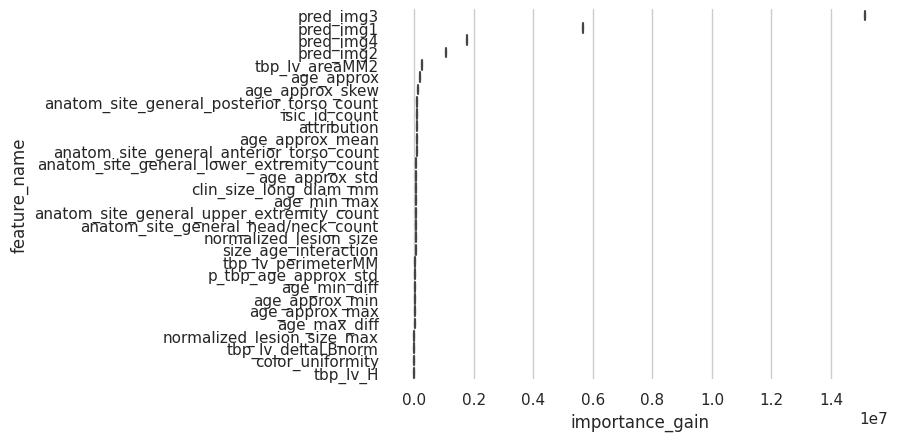

In [60]:
plot_feature_importance(lgb_trainer.clfs, model_type="lgb", top_n=30)

In [61]:
# XGBoost Training
params_xgb = {
    'objective':  'binary:logistic',
    'eval_metric': 'logloss',
    "nthread": -1,
    "learning_rate" : 0.01,
    'colsample_bytree': 0.5,
    'subsample': 0.6,
    'max_depth': 7,
    'lambda': 8,
    'tree_method':"hist",
    'device':"cuda",
    'scale_pos_weight':20
}
xgb_trainer = XGBoostTrainer(
    train_df, past_train_df, params_xgb, predictors, "xgb", True, 1, 100
)
oof_xgb, scores = xgb_trainer.fit()

training fold 0_seed 0
[0]	train-logloss:0.41967	eval-logloss:0.40385
[100]	train-logloss:0.18066	eval-logloss:0.13834
[200]	train-logloss:0.11302	eval-logloss:0.05549
[300]	train-logloss:0.09102	eval-logloss:0.02620
[400]	train-logloss:0.08333	eval-logloss:0.01509
[500]	train-logloss:0.08037	eval-logloss:0.01074
[600]	train-logloss:0.07866	eval-logloss:0.00870
[700]	train-logloss:0.07705	eval-logloss:0.00746
[800]	train-logloss:0.07556	eval-logloss:0.00665
[900]	train-logloss:0.07415	eval-logloss:0.00618
[1000]	train-logloss:0.07272	eval-logloss:0.00588
[1100]	train-logloss:0.07138	eval-logloss:0.00571
[1200]	train-logloss:0.07016	eval-logloss:0.00554
[1300]	train-logloss:0.06901	eval-logloss:0.00544
[1400]	train-logloss:0.06790	eval-logloss:0.00538
[1500]	train-logloss:0.06689	eval-logloss:0.00532
[1600]	train-logloss:0.06578	eval-logloss:0.00525
[1700]	train-logloss:0.06482	eval-logloss:0.00522
[1800]	train-logloss:0.06389	eval-logloss:0.00519
[1900]	train-logloss:0.06304	eval-loglo

In [62]:
calculate_oof_scores(train_df, oof_xgb)

Fold 0 score: 0.17842925845840552
Fold 1 score: 0.18219316380433603
Fold 2 score: 0.1897813151167536
Fold 3 score: 0.1641812238976425
Fold 4 score: 0.18523502194074162
cv score: 0.17996399664357587
oof score: 0.1780787920682039


(0.17996399664357587, 0.1780787920682039)

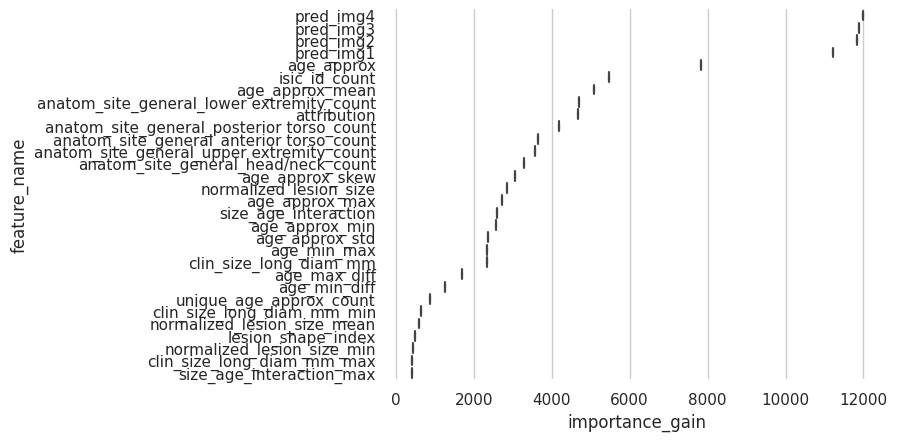

In [63]:
plot_feature_importance(xgb_trainer.clfs, model_type="xgb", top_n=30)

In [65]:
ensemble_oof_df = train_df[["isic_id", "target"]].copy()
w_1 = 0.7
w_2 = 0.3
oof_ensemble = (w_1 * oof_lgb) + (w_2 * oof_xgb)
ensemble_oof_df["pred"] = oof_ensemble
calculate_oof_scores(train_df, oof_ensemble)
ensemble_oof_df.to_csv(OUTOUT_DIR / "ensemble_oof_df.csv", index=False)

Fold 0 score: 0.17855475587582667
Fold 1 score: 0.1812434733217617
Fold 2 score: 0.1907381151854954
Fold 3 score: 0.1752607132332543
Fold 4 score: 0.18776896771500565
cv score: 0.18271320506626873
oof score: 0.18156238311049247
